This notebook does the same thing that Synthetic_Mars_Wind_Profile.ipynb but for several files in row.

In [18]:
# %matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from local_utils import *
import matplotlib.dates as md

kappa = 0.4

# path = '/Users/brian/Documents/research/Active Projects/Measuring_Wind_with_Ingenuity/code/MEDA_WS_Data/'
path = './MEDA_WS_Data/'
file_list_name = path + "xml_list.txt"
file_list = np.genfromtxt(file_list_name, dtype=str)

time, wind = retrieve_time_wind(path + file_list[1])
correct_zstar = 2. # cm
correct_ustar = kappa*np.mean(wind)/np.log(zs[0]/correct_zstar)
print(correct_ustar)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Processing label: ./MEDA_WS_Data/WE__0091___________DER_WS__________________P02.xml
Now processing a Header structure: HEADER
Now processing a Table_Delimited structure: TABLE
0.22308048720800977


In [22]:
# Show baseline data for all files - Don't run unless you want a giant file.
# for file_name in file_list:

#     WS_file = path + file_name
#     sol = WS_file.split('__')[1]

#     fig = plt.figure(figsize=(10*aspect_ratio, 10))
#     ax = fig.add_subplot(111)

#     time, wind = retrieve_time_wind(WS_file)
#     ax.scatter(time, wind, marker='.', color=BoiseState_blue)
#     ax.text(0.05, 0.9, "Sol %s" % (sol), fontsize=28, transform=ax.transAxes)

#     xfmt = md.DateFormatter('%H:%M:%S')
#     ax.xaxis.set_major_formatter(xfmt)
#     ax.grid(True)
#     ax.tick_params(axis="x", labelsize=12)
#     ax.tick_params(axis="y", labelsize=36)
#     ax.set_xlabel("LMST", fontsize=36)
#     ax.set_ylabel(r'$U\ \left( {\rm m\ s^{-1}} \right)$', fontsize=36)
    
#     savefig_name = WS_file.replace(".xml", "_%s_%s.png" %\
#                                    (np.min(time).strftime("%H-%M-%S"), np.max(time).strftime("%H-%M-%S")))
#     fig.savefig(savefig_name, dpi=300, bbox_inches="tight")

0076
Processing label: ./MEDA_WS_Data/WE__0076___________DER_WS__________________P02.xml
Now processing a Header structure: HEADER
Now processing a Table_Delimited structure: TABLE
0091
Processing label: ./MEDA_WS_Data/WE__0091___________DER_WS__________________P02.xml
Now processing a Header structure: HEADER
Now processing a Table_Delimited structure: TABLE
0107
Processing label: ./MEDA_WS_Data/WE__0107___________DER_WS__________________P02.xml
Now processing a Header structure: HEADER
Now processing a Table_Delimited structure: TABLE
0133
Processing label: ./MEDA_WS_Data/WE__0133___________DER_WS__________________P02.xml
Now processing a Header structure: HEADER
Now processing a Table_Delimited structure: TABLE
0152
Processing label: ./MEDA_WS_Data/WE__0152___________DER_WS__________________P02.xml
Now processing a Header structure: HEADER
Now processing a Table_Delimited structure: TABLE
0241
Processing label: ./MEDA_WS_Data/WE__0241___________DER_WS__________________P02.xml
Now pr

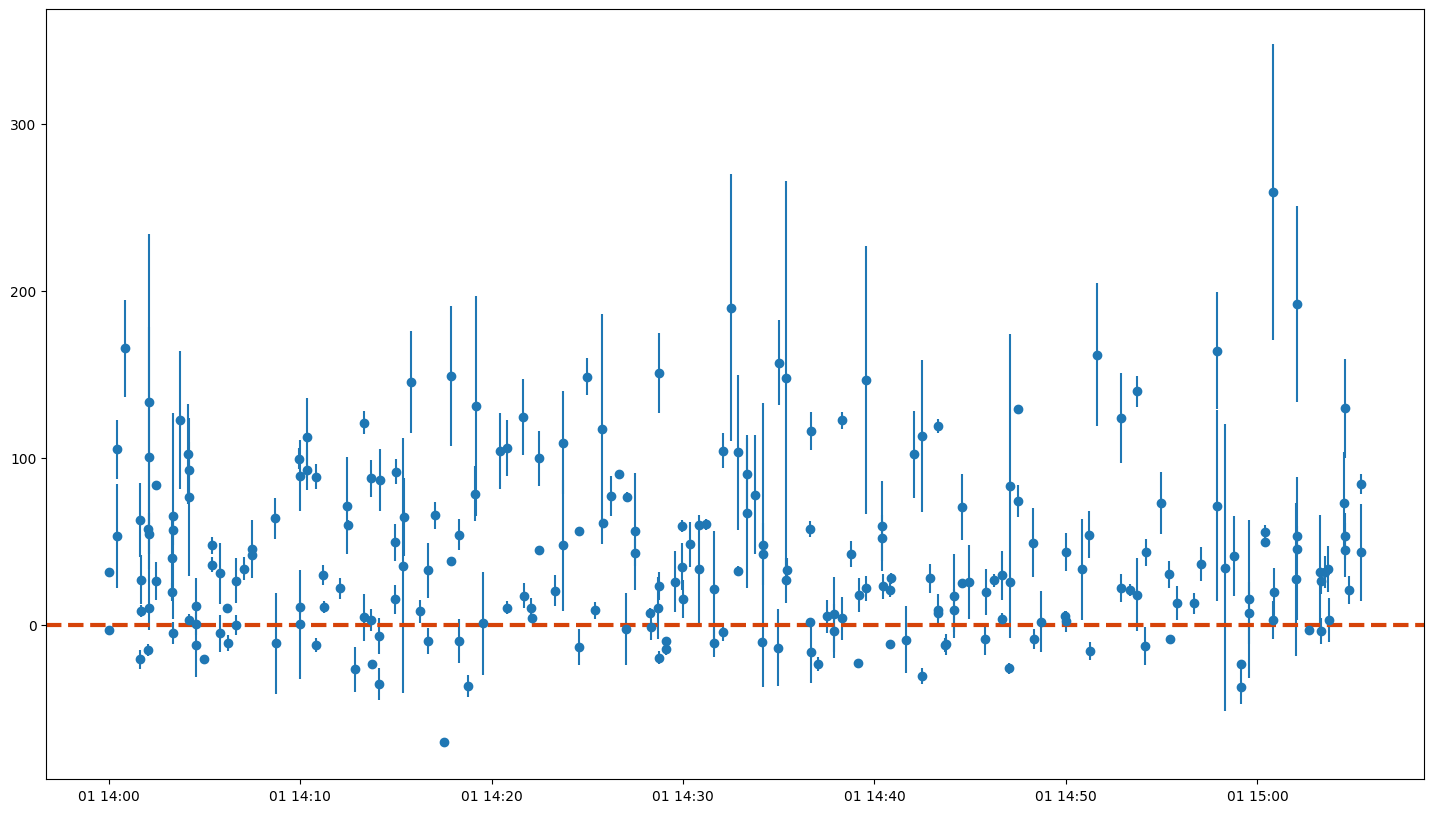

In [19]:
fig = plt.figure(figsize=(10*aspect_ratio, 10))
ax = fig.add_subplot(111)

correct_ustars = np.array([])
saved_ustars = np.array([])
saved_zstars = np.array([])
saved_min_averaged_windspeeds = ([])
saved_min_std_windspeeds = ([])
saved_sigma_ustars = np.array([])
saved_sigma_zstars = np.array([])
saved_sols = np.array([])
saved_t0s = np.array([])

num_tries = 0
num_successes = 0

for WS_file in file_list:
    sol = WS_file.split('__')[1]
    print(sol)

#     time, wind = retrieve_time_wind(path + WS_file, 
#                                     start_time=datetime(1900, 1, 1, 12, 0, 0), 
#                                     end_time=datetime(1900, 1, 1, 13, 0, 0))

    time, wind = retrieve_time_wind(path + WS_file)
    # Convert to cm/s
    wind *= 100.
    
    if(len(time) == 0):
        continue
    
    sampling = time[1] - time[0]
    num_points_expected = len(zs)*sample_time/sampling
    # Create synthetic wind profile, converting wind speeds to cm/s
    scaled_windspeeds = create_synthetic_wind_profile(wind, zs, correct_zstar, z0=np.min(zs))

    # 2023 Sep 13 - Brown tells me the drone samples at 500 Hz. 
    # If we fold in a 6 m/s scatter but at 500 Hz for sampling, that works out to 
    # \sigma = (6 m/s)/np.sqrt(500) = 0.3 m/s scatter on each data point
    attitude_scatter = 600./np.sqrt(500.) # cm/s
    for i in range(len(scaled_windspeeds[:,0])):
        scaled_windspeeds[i,:] += normal(scale=attitude_scatter, size=len(scaled_windspeeds[i,:]))

    # Cycle through the whole timeseries, sampling windows sample_time across
    t0 = np.min(time)
    while((t0 + sample_time) < np.max(time)):
              
        # Need to check that there are not gaps in the time-series
        points = retrieve_relevant_times(time, t0, len(zs)*sample_time)
        if(len(time[points]) >= num_points_expected):
        
            averaged_windspeeds, std_windspeeds =\
                sample_wind_profile(sample_time, t0, time, scaled_windspeeds, zs, settle_time=settle_time)

#             ustar, zstar, sigma_ustar, sigma_zstar, std_windspeeds =\
#                 fit_wind_profile_scaled_values(zs, averaged_windspeeds, std_windspeeds, rescale_unc=False)

            num_tries += 1
            inlier_zs, inlier_averaged_windspeeds, inlier_std_windspeeds,\
                outlier_zs, outlier_averaged_windspeeds, outlier_std_windspeeds,\
                popt, unc, pcov = fit_wind_profile_and_drop_outliers(zs, averaged_windspeeds, std_windspeeds,
                                                                     drop_outliers=True, num_sigma=5., 
                                                                     rescale_unc=False,
                                                                     consider_scaled_uncertainties=False)
            if(len(popt) == 2):
                num_successes += 1
                # Collect ustar and zstar and uncertainties
                ustar, zstar, sigma_ustar, sigma_zstar = collect_fit_values_and_unc(popt, unc, pcov)

                # Collect ustar and zstar and uncertainties - Check that the fit worked
                correct_ustars =\
                    np.append(correct_ustars, kappa*averaged_windspeeds[0]/np.log(zs[0]/correct_zstar))

                saved_sols = np.append(saved_sols, sol)
                saved_t0s = np.append(saved_t0s, t0)
                saved_ustars = np.append(saved_ustars, ustar)
                saved_zstars = np.append(saved_zstars, zstar)
                saved_sigma_ustars = np.append(saved_sigma_ustars, sigma_ustar)
                saved_sigma_zstars = np.append(saved_sigma_zstars, sigma_zstar)

                ind = np.argmin(averaged_windspeeds)
                saved_min_averaged_windspeeds = np.append(saved_min_averaged_windspeeds, averaged_windspeeds[ind])
                saved_min_std_windspeeds = np.append(saved_min_std_windspeeds, std_windspeeds[ind])

        # Advance as far long as the previous sampling length over all windows
        t0 += sample_time*len(zs)
        
print("num_tries, num_successes: ", num_tries, num_successes)
# ind = np.argmax(saved_zstars)
# print(saved_sols[ind], saved_t0s[ind], saved_zstars[ind])
        
# ax.scatter(saved_min_std_windspeeds, saved_zstars)
# plt.plot(saved_zstars, ls='', marker='.')
# plt.ylim([0, 60])

# ind = (np.abs(saved_zstars - correct_zstar)/saved_sigma_zstars < 3.) & (saved_zstars/saved_sigma_zstars > 1.)
# print(len(saved_zstars[ind]))
# plt.plot(saved_sigma_zstars[ind], ls='', marker='o')


# plt.errorbar(np.arange(len(saved_zstars)), saved_zstars, yerr=saved_sigma_zstars, ls='', marker='.')
# plt.scatter(saved_zstars, saved_sigma_zstars, ls='', marker='.')

# print(len(correct_ustars),len(saved_ustars))

# ax.plot(saved_zstars, ls='', marker='o')

# ax.plot(saved_sols, saved_zstars, ls='', marker='o')
# ax.plot(saved_t0s, saved_zstars, ls='', marker='o')

# ax.errorbar(saved_t0s, saved_zstars, yerr=saved_sigma_zstars, ls='', marker='o')
# ax.set_ylim([0, 20])

# ax.errorbar(saved_t0s, saved_ustars - correct_ustars, yerr=saved_sigma_ustars, ls='', marker='o')

# ind = (saved_sigma_zstars > 0.) & ((saved_zstars/saved_sigma_zstars) > 3.)  &\
#     (np.abs(saved_zstars - correct_zstar)/saved_sigma_zstars < 3.)
# ax.errorbar(saved_t0s[ind], saved_zstars[ind], yerr=saved_sigma_zstars[ind], ls='', marker='o')
# ax.errorbar(saved_t0s, saved_zstars, yerr=saved_sigma_zstars, ls='', marker='o')

# xfmt = md.DateFormatter('%H:%M:%S')
# ax.xaxis.set_major_formatter(xfmt)

# ax.plot(correct_ustars, saved_ustars , ls='', marker='o')
# ax.plot([np.min(correct_ustars), np.max(correct_ustars)], [np.min(correct_ustars), np.max(correct_ustars)], 
#        color=BoiseState_orange)

# ind = saved_zstars/saved_sigma_zstars > 3
# aind = (np.abs(saved_zstars - correct_zstar)/saved_sigma_zstars < 3) & (saved_sigma_zstars > 0.) &\
#     (saved_sigma_zstars < 2.)
# bind = (saved_sigma_zstars > 0.)
# print(len(saved_zstars[aind]), len(saved_zstars[bind]))
# ax.plot(saved_t0s[aind], saved_zstars[aind], marker='o', markersize=10, color=BoiseState_orange, ls='')
# ax.errorbar(saved_ustars[ind] - correct_ustars[ind], saved_zstars[ind], 
#             xerr=saved_sigma_ustars[ind], yerr=saved_sigma_zstars[ind], 
#             ls='', marker='o', color=BoiseState_blue)
# ax.axhline(correct_zstar, ls='--', lw=3, color=BoiseState_orange)
# ax.axhline(0., ls='--', lw=3, color=BoiseState_orange)
ind = (np.abs(saved_ustars - correct_ustars)/saved_sigma_ustars < 3.) & (saved_ustars/saved_sigma_ustars > 1.)

ax.errorbar(saved_t0s, saved_ustars - correct_ustars, yerr=saved_sigma_ustars, ls='', marker='o')
# print(len(saved_ustars[ind]), len(saved_ustars))
ax.axhline(0., ls='--', lw=3, color=BoiseState_orange)

# print(np.median(saved_zstars - correct_zstar), 
#       np.median((saved_zstars - correct_zstar)/saved_sigma_zstars), 
#       np.median(saved_ustars - correct_ustars), 
#       np.median((saved_ustars - correct_ustars)/saved_sigma_ustars))

# ax.set_ylim([-10, 100])
# ax.grid(True)
# ax.tick_params(labelsize=18)
# ax.set_xlabel(r'$u_\star\,\left( {\rm cm\ s^{-1}} \right)$', fontsize=24)
# ax.set_ylabel(r'$z_\star\,\left( {\rm cm} \right)$', fontsize=24)

0.6419753086419753


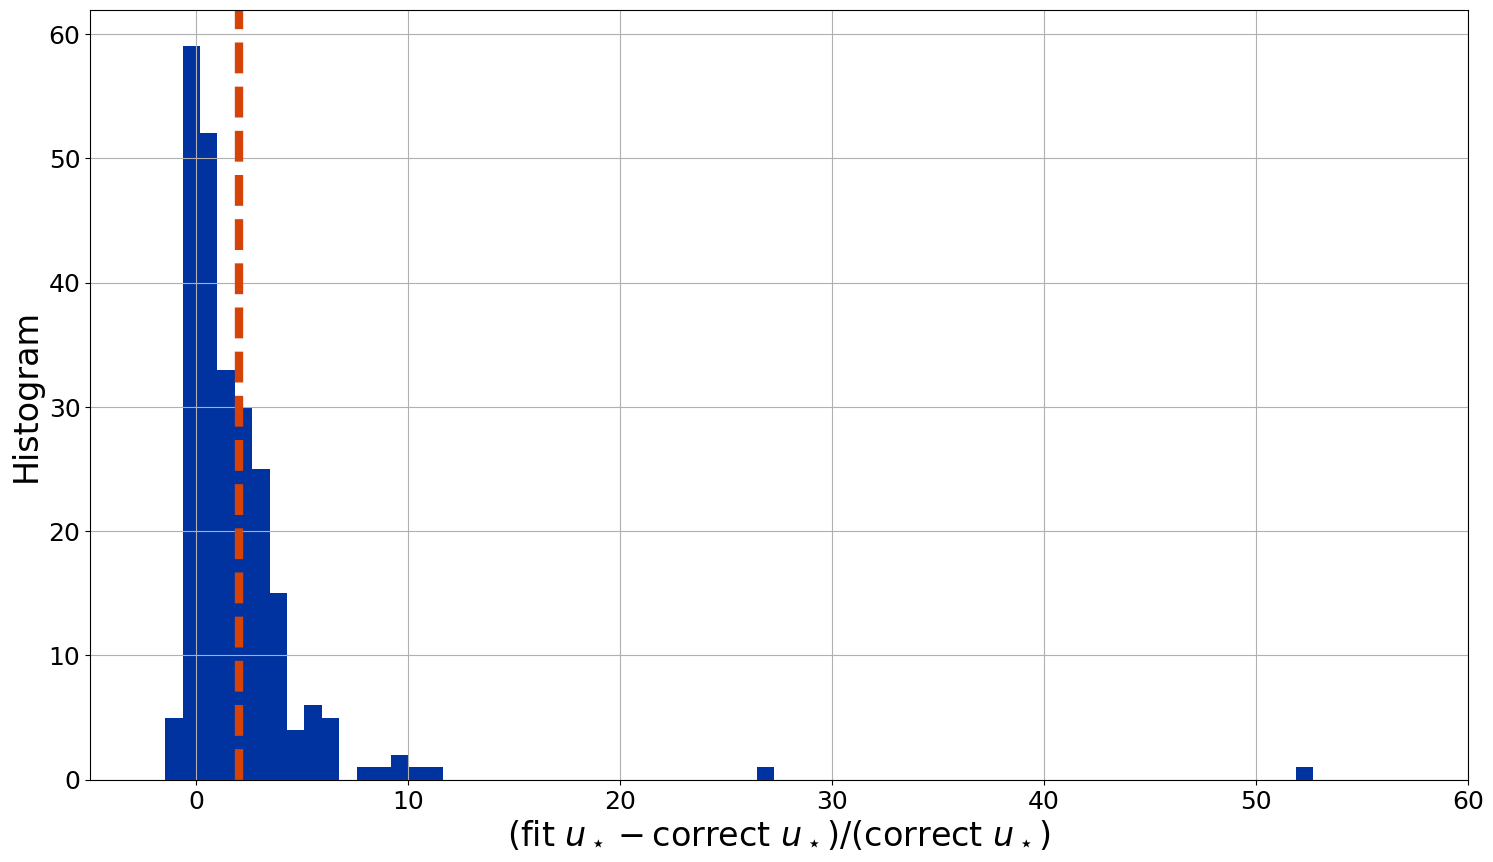

In [26]:
fig = plt.figure(figsize=(10*aspect_ratio, 10))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist((saved_ustars - correct_ustars)/correct_ustars, bins='auto', color=BoiseState_blue);
ax.axvline(2., color=BoiseState_orange, ls='--', lw=6)

ax.tick_params(labelsize=18)
ax.set_xlabel(r'$\left({\rm fit}\ u_\star - {\rm correct}\ u_\star\right)/\left( {\rm correct}\ u_\star\right)$',
              fontsize=24)
ax.set_ylabel("Histogram", fontsize=24)
ax.grid(True)

ax.set_xlim([-5, 60])

x = (saved_ustars - correct_ustars)/correct_ustars
print(len(x[x < 2])/len(x))

fig.savefig("ustar_histogram_5-second-hover_1400LMST.png", dpi=300, bbox_inches="tight")
# 0.6419753086419753
# fig.savefig("ustar_histogram_12-second-hover_1400LMST.png", dpi=300, bbox_inches="tight")
# 0.717948717948718

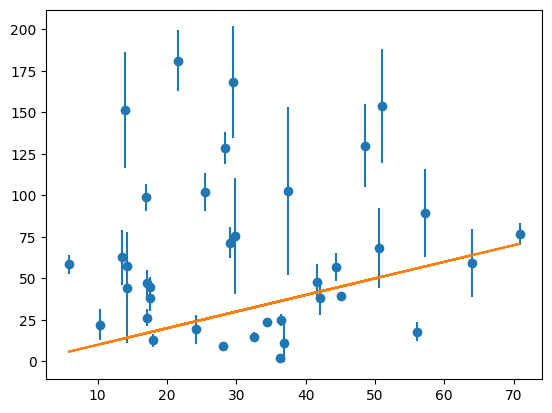

In [45]:
plt.errorbar(correct_ustars, saved_ustars, yerr=saved_sigma_ustars, marker='o', ls='')
plt.plot(correct_ustars, correct_ustars)

60 127
6 127


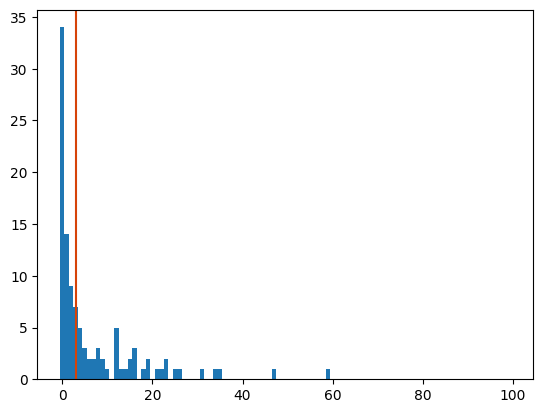

In [56]:
n, bins, patches = plt.hist(saved_zstars, bins=np.arange(-0.5, 100.5));
plt.axvline(correct_zstar, color=BoiseState_orange)

print(len(saved_zstars[saved_zstars <= correct_zstar]), len(saved_zstars))
ind = (saved_sigma_zstars > 0.) & ((saved_zstars/saved_sigma_zstars) > 3.)  &\
    (np.abs(saved_zstars - correct_zstar)/saved_sigma_zstars < 3.)
print(len(saved_zstars[ind]), len(saved_zstars))

(-5.0, 5.0)

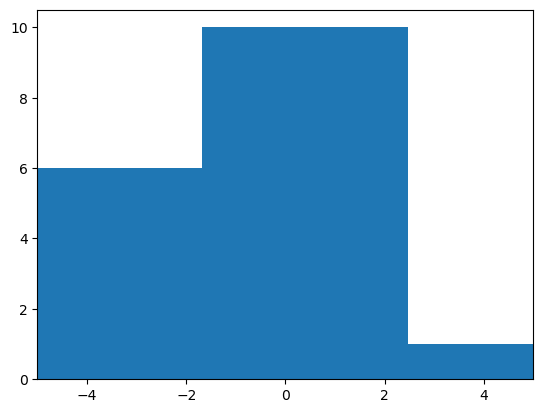

In [32]:
n, bins, patches = plt.hist((saved_ustars - correct_ustars)/saved_sigma_ustars, bins='auto');
plt.xlim([-5, 5])

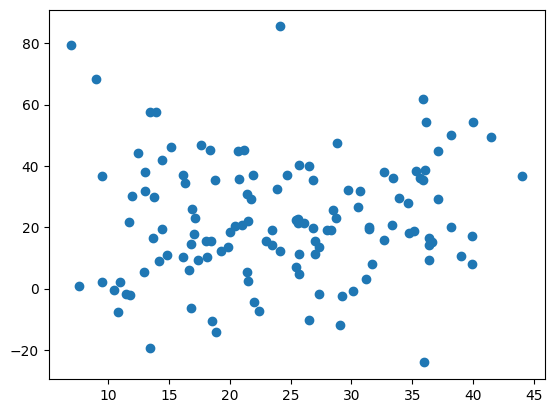

In [36]:
plt.scatter(correct_ustars, saved_ustars)